# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

### referred

https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_1samp.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests

df = pd.read_csv('data/human_body_temperature.csv')

## 1. Is the distribution of body temperatures normal?

In [2]:
# we will reuse the ecdf formula created during lectures
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x= np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

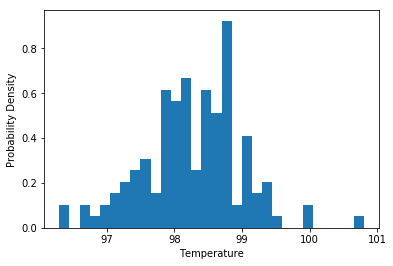

In [3]:
temperature = df['temperature']

#_=plt.hist(temperature,bins=100)
_=plt.hist(temperature,bins=30,density=True)
_=plt.xlabel('Temperature')
_=plt.ylabel('Probability Density')
plt.show()

The distribution itself seems pretty normal.  Identifying whether the observed data is normal or not using histogram can be tricky as the "look" of the histogram can vary a lot by the size of bins.

All we need to take away from this histogram is the general dispersity of data and where the data are closely gathered (mean).
We will look at other means of comparison.

In [4]:
#let's take the mean and std of the empirical data and use it to take a random normal sample of 10000
temp_mean = np.mean(temperature)
temp_std = np.std(temperature)

#we use np.random.normal to do this
sample_temp = np.random.normal(temp_mean,temp_std,10000)

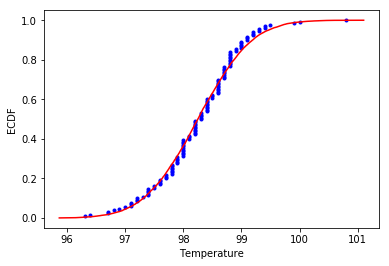

In [5]:
#take the data and its cumulative distributive function value to x,y
x,y=ecdf(temperature)

_=plt.plot(x,y,marker='.',linestyle='none',color='blue')
_=plt.xlabel('Temperature')
_=plt.ylabel('ECDF')

#we do the same with the normal sample that we took
sample_x, sample_y = ecdf(sample_temp)
_=plt.plot(sample_x,sample_y,color='red')

plt.show()

Here, we have overlayed the empirical cumulative distribution function of the observered data in blue with the cdf of our normally sampled data.
We can see here that both are almost an exact match and can conclude that our empirical data follows a normal distribution.

## 2. Is the sample size large? Are the observations independent?

Three most important conditions for CLT is : 

1) Is it independent?

We can safely say that measuring temperature and heart rate of person A will not affect the measurement of person B.
So, yes.

2) Is it randomly sampled?

Although not explicitly stated, it is safe to assume the data is randomly sampled as non-random sampling would mean there is a specific pool where these people were chosen from. 

3) Is the sample size large?

In a lot of cases, large sample size that meets the CLT condition is considered above 30.  We have 130 data points.

## 3. Is the true population mean really 98.6 degrees F?

First, try a bootstrap hypothesis test.
Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
In this situation, is it appropriate to use the  𝑡  or  𝑧  statistic?
Now try using the other test. How is the result be different? Why?

In [6]:
#define bootstrap methods

def bootstrap_replicate_1d(data, func):
    '''Takes in 1d array of data and outputs a resampled array of size input array.
    The method also takes in an aggregate function to apply to the resampled data for bootstrap replicate'''
    return func(np.random.choice(data, size=len(data)))


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [7]:
#Bootstrap test

#this is a test to see if the method is working correctly.
bs_temp = bootstrap_replicate_1d(temperature, np.mean)

#the mean is relatively close to the value we are expecting.  We can continue
print(bs_temp)
print(np.mean(temperature))

98.18923076923078
98.24923076923078


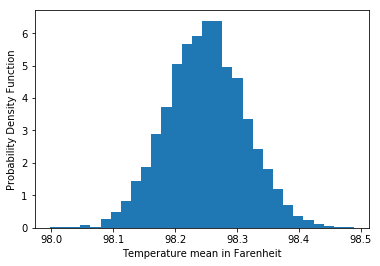

In [8]:
#bs_temp_rep contains 10000 mean values that were calculated out of 10000 different permutation of our temperature data
bs_temp_rep = draw_bs_reps(temperature, np.mean, 10000)

#plotting histogram of bootstrap replicates
_= plt.hist(bs_temp_rep, bins=30,density=True)
_= plt.xlabel('Temperature mean in Farenheit')
_= plt.ylabel('Probability Density Function')
plt.show()

We created a pdf of the bootstrap replicates we generated.  With this data, we can create a confidence interval where if we took 10000 samples like above multiple times, where the mean would fall 95% of the times. (significance level = .05)

In [9]:
#np.percentile takes in the 1d array and list of percentage values. 
conf_int_temp = np.percentile(bs_temp_rep,[2.5,97.5])
print(conf_int_temp)

[98.12307692 98.37461538]


With the above range from 98.12 ~ 98.38 , we cannot prove that true mean body temperature is 98.6.  We can say that is lies somewhere within the above range 95% of the times.

Hypothesis test

Ho : True population mean temperature = 98.6

Ha : True population mean tempearture < 98.6

This would be a one-sample z test as we have a large sample size.

In [10]:
#making an array of translated temperature mean.  we do this by adding the population mean and subtracting our mean
trans_temp = temperature + 98.6 - np.mean(temperature)

#take bootstrap replicates of trans_temp
bs_trans_temp_rep = draw_bs_reps(trans_temp,np.mean,10000)

print(bs_trans_temp_rep)

[98.64538462 98.53153846 98.60076923 ... 98.73076923 98.52076923
 98.63615385]


In [11]:
#get p value by computing fraction of reps that are <   > than the observed temperature
p=np.sum(bs_trans_temp_rep <= np.mean(temperature))/10000
print(p)

0.0


In [12]:
#z test using scipy
ztest, pval = stests.ztest(temperature,x2=None, value=98.6)
print(ztest,pval)

-5.4548232923645195 4.9021570141012155e-08


p-value is 0 from our bootstrap hypothesis testing and very low number from our ztest, so the sample mean cannot be the same as population mean.  Either we have taken a very outlying sample or true mean is not 98.6.  For now, we can reject the null hypothesis.

one sample T test method



In [13]:
#t test using scipy
ttest, pval = stats.ttest_1samp(temperature,98.6)
print(ttest,pval)

-5.4548232923645195 2.4106320415561276e-07


p value on the t test is also very small but not 0.  So we will reject null hypothesis here as well.
z statistic and t statistics are of same value but p values are different.

## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [14]:
#initially drew sample using np.random.choice but the results were keep changing.
#to keep the answer consistent, we will pick from data

#pick every 5th temp data and get the first 10
mini_temperature = temperature[::5][:10]

In [15]:
#z test

ztest, pval = stests.ztest(mini_temperature,x2=None, value=98.6)
print(ztest,pval)

ttest, pval = stats.ttest_1samp(temperature,98.6)
print(ttest,pval)

0.28423572284298276 0.7762297410426022
-5.4548232923645195 2.4106320415561276e-07


With sample size below 30, t test is what we should be using.  And as expected, t test gave us the same value like before but z test has given a completely different value.

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

In question 3, we already calculated our 95% confidence interval for human temerature.  Any temperature outside of range, [98.12307692 98.37461538], will be considered abnormal.

## 6. Is there a significant difference between males and females in normal temperature?

In [18]:
#first extract the relevant data
male = df.loc[df['gender']=='M']['temperature']
female =  df.loc[df['gender']=='F']['temperature']


For this question, we will use two sided z test with significance level of 0.05. 

Ho : male temp mean - female temp mean = 0

Ha : male temp mean - female temp mean != 0


In [19]:
ztest1,pval1 = stests.ztest(male,x2=female,value=0,alternative='two-sided')
print(ztest1,pval1)

-2.2854345381656103 0.02228736076065755


Hypothesis test shows that male body temperature and female body temperature mean are different.  According to the z test statistic being negative, it means that male body temperature is likely to be lower than of female.
The data shows that there is only 2% chance where this could happen IF male and female mean body temperature were equal.